# CSV Backtester — Step-by-Step Validation
This notebook walks through the pipeline: data → buffer → strategies → orders → execution → reporting.

## 0. Setup

In [40]:
import os, datetime, matplotlib.pyplot as plt
from collections import deque
from typing import List, Tuple

from data_loader import load_market_data, MarketDataPoint
from models import Order, OrderError, ExecutionError
from strategies import MomentumStrategy, MeanReversionStrategy
from engine import ExecutionEngine
import reporting

os.makedirs("data", exist_ok=True)
os.makedirs("output", exist_ok=True)
print("Folders ready.")

Folders ready.


## 1. Generate or Load CSV

In [41]:
# Generate a synthetic CSV if not present
csv_path = os.path.join("data", "market_data.csv")
if not os.path.exists(csv_path):
    from data_generator import generate_market_csv
    generate_market_csv("AAPL", 150.0, csv_path, num_ticks=6000, volatility=0.01, interval=0.0)
print("CSV at:", csv_path)

CSV at: data/market_data.csv


## 2. Parse CSV → Immutable `MarketDataPoint` List

In [42]:
ticks: List[MarketDataPoint] = load_market_data(csv_path)
ticks[:3]  # preview first 3

[MarketDataPoint(timestamp=datetime.datetime(2025, 9, 21, 22, 58, 50, 781440), symbol='AAPL', price=152.26),
 MarketDataPoint(timestamp=datetime.datetime(2025, 9, 21, 22, 58, 50, 781498), symbol='AAPL', price=153.38),
 MarketDataPoint(timestamp=datetime.datetime(2025, 9, 21, 22, 58, 50, 781509), symbol='AAPL', price=154.63)]

## 3. FIFO Buffer (length 150)

In [43]:
buffer = deque(maxlen=150)
for t in ticks[:10]:
    buffer.append(t)
len(buffer), buffer[0], buffer[-1]

(10,
 MarketDataPoint(timestamp=datetime.datetime(2025, 9, 21, 22, 58, 50, 781440), symbol='AAPL', price=152.26),
 MarketDataPoint(timestamp=datetime.datetime(2025, 9, 21, 22, 58, 50, 781587), symbol='AAPL', price=155.54))

## 4. Strategies Setup and First Signals

In [44]:
symbol = ticks[0].symbol
mom = MomentumStrategy(symbol, lookback=20, qty=1, threshold=0.05)
mr = MeanReversionStrategy(symbol, window=50, z_entry=1.0, qty=1)

sample_signals = []
for t in ticks[:80]:  # enough to warm up both strategies
    sample_signals.extend(mom.generate_signals(t))
    sample_signals.extend(mr.generate_signals(t))
len(sample_signals), sample_signals[:15]

(80,
 [('BUY', 'AAPL', 1, 162.11),
  ('BUY', 'AAPL', 1, 161.16),
  ('BUY', 'AAPL', 1, 159.93),
  ('BUY', 'AAPL', 1, 161.69),
  ('BUY', 'AAPL', 1, 160.66),
  ('BUY', 'AAPL', 1, 161.34),
  ('BUY', 'AAPL', 1, 162.95),
  ('BUY', 'AAPL', 1, 163.65),
  ('BUY', 'AAPL', 1, 164.6),
  ('BUY', 'AAPL', 1, 168.67),
  ('BUY', 'AAPL', 1, 169.69),
  ('BUY', 'AAPL', 1, 170.19),
  ('BUY', 'AAPL', 1, 170.4),
  ('BUY', 'AAPL', 1, 168.77),
  ('BUY', 'AAPL', 1, 166.92)])

## 5. Create Orders from Signals and Validate

In [45]:
orders = [Order(symbol=s, quantity=q, price=p, side=a) for (a, s, q, p) in sample_signals]
# Validate all (some may be invalid depending on config)
valid_orders = []
for o in orders:
    try:
        o.validate()
        valid_orders.append(o)
    except OrderError as e:
        pass
len(valid_orders)

80

## 6. Execution Engine — Step First 120 Ticks

In [46]:
engine = ExecutionEngine(starting_cash=100_000.0, success_rate=0.9)
for t in ticks[:120]:
    engine.on_tick(t)
    for sig in mom.generate_signals(t) + mr.generate_signals(t):
        o = Order(symbol=sig[1], quantity=sig[2], price=sig[3], side=sig[0])
        try:
            o.validate()
            try:
                engine.execute(o, now=t.timestamp)
            except ExecutionError:
                # Simulated failure; continue
                pass
        except OrderError:
            # Invalid order; skip
            pass

len(engine.executed_history), len(engine.failed_history), len(engine.portfolio_values)

(155, 26, 120)

### Plot interim equity

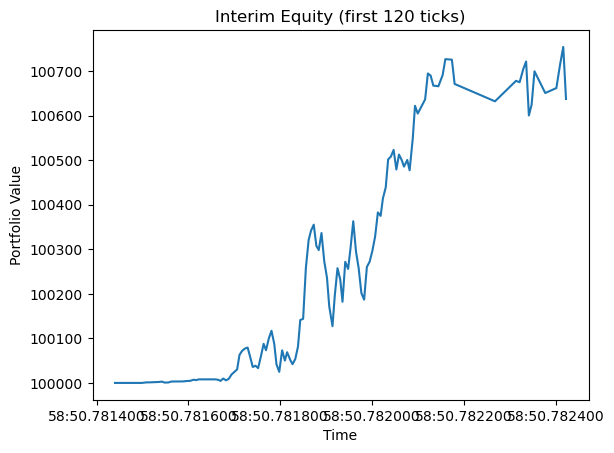

In [47]:
xs = [t for t, _ in engine.portfolio_values]
ys = [v for _, v in engine.portfolio_values]
plt.figure()
plt.plot(xs, ys)
plt.title("Interim Equity (first 120 ticks)")
plt.xlabel("Time"); plt.ylabel("Portfolio Value"); plt.show()

## 7. Full Backtest

In [48]:
# Continue for all ticks
engine_full = ExecutionEngine(starting_cash=100_000.0, success_rate=0.9)
for t in ticks:
    engine_full.on_tick(t)
    for sig in mom.generate_signals(t) + mr.generate_signals(t):
        o = Order(symbol=sig[1], quantity=sig[2], price=sig[3], side=sig[0])
        try:
            o.validate()
            try:
                engine_full.execute(o, now=t.timestamp)
            except ExecutionError:
                pass
        except OrderError:
            pass

len(engine_full.executed_history), len(engine_full.failed_history), len(engine_full.portfolio_values)

(8390, 990, 6000)

### 8. Reporting

In [49]:
out_md = reporting.generate_markdown_report("output", engine_full)
print("Report written to:", out_md)
# Display paths
out_md, os.path.join("output", "equity.png")

Report written to: output/performance.md


('output/performance.md', 'output/equity.png')

### 9. Inspect Markdown

In [50]:
# Show first 40 lines of the markdown
with open(out_md, "r") as f:
    for i, line in enumerate(f):
        if i > 40: break
        print(line.rstrip())

# Performance Report
## Summary Metrics
| Metric | Value |
|---|---|
| Starting Equity | 100000.00 |
| Ending Equity | 100272.01 |
| Total Return | 0.27% |
| Sharpe (per-tick scaled) | 0.14 |
| Max Drawdown | -7.24% |

## Equity Curve
![Equity](equity.png)

## ASCII Sparkline
```
▃▄▄▄▃▅▅▅▅▅▅▆▅▅▅▆▅▅▅▄▄▄▄▄▄▄▄▄▂▂▁▂▄▅▆█▆▁▂▁▁▂▄▃▄▃▃▃▃▅▄▅▅▅▄▄▄▃▃▃
```
## Executions
- Executed orders: 8390
- Failed orders: 990

### First 5 Executions
```
{'timestamp': '2025-09-21T22:58:50.781440', 'symbol': 'AAPL', 'price': 152.26, 'quantity': 1, 'side': 'BUY', 'status': 'FILLED', 'cash_after': 99847.74, 'position_after': 1}
{'timestamp': '2025-09-21T22:58:50.781498', 'symbol': 'AAPL', 'price': 153.38, 'quantity': 1, 'side': 'SELL', 'status': 'FILLED', 'cash_after': 100001.12000000001, 'position_after': 0}
{'timestamp': '2025-09-21T22:58:50.781498', 'symbol': 'AAPL', 'price': 153.38, 'quantity': 1, 'side': 'BUY', 'status': 'FILLED', 'cash_after': 99847.74, 'position_after': 1}
{'timestamp': '2025-09-21T22:58:50